In [1]:
# using Pkg
# Pkg.activate("..")
# Pkg.instantiate();

In [19]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using CSV
using DataFrames
using MAT
using JLD
using Parameters
import ProgressMeter

In [20]:
import ReactiveMP.messageout

In [21]:
data_seed, params_seed = 42, 420

(42, 420)

### Load data

In [22]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [23]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

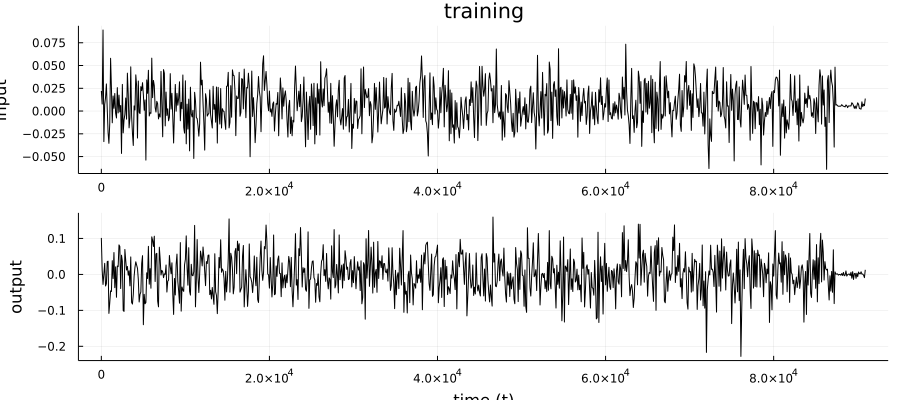

In [342]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

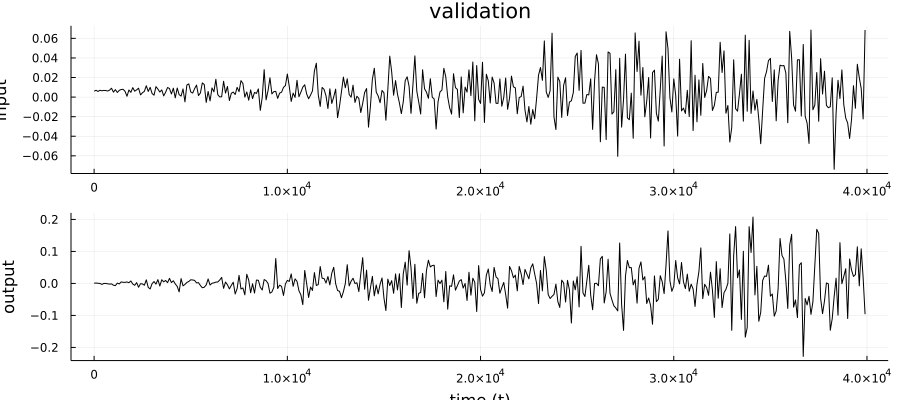

In [343]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### Model

In [26]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end

In [348]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    proxy_message_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    marginal_in = prod(ProdAnalytical(), proxy_message_in, m_in)
    
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [349]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [350]:
melu(x) = clamp(x, convert(Float64, tiny), Inf)
Base.Float64(x::HugeNumber) = convert(Float64, x)

In [351]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h+1); H[full_order-order_h+1:full_order, 2:order_h+1] = diageye(order_h);

In [352]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [405]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e2;
    obs_prec = 1e2
    
    params_flow = model_params[1:end-order-2]
    params_dot  = model_params[end-order-1:end-2]
    params_w    = model_params[end-1:end]
    
    b = params_dot;
    

    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))}
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
#     Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order))
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order+1, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    θ ~ MvNormalMeanPrecision(zeros(h_order+1), prec*diageye(h_order+1))
    
    S = shift(order_h+1);
    c = zeros(order_h+1); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
#         h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t] + dot(h[t], c), obs_prec) where { q = MeanField()}
        h_prev = h[t]
    end

    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
end

nonlinear_max_mv (generic function with 1 method)

In [406]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order+1), 0.1*diageye(h_order+1)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    params_w    = params[end-1:end]
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    
    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [407]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

### Prepare data

In [408]:
train_size = 800
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

# X_train, Y_train, U_train = 100*X_train, 100*Y_train, 100*U_train
# X_test, Y_test, U_test = 100*X_test, 100*Y_test, 100*U_test

### Train model

In [409]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; randn(full_order)/10; [1e3, 1.0]]

53-element Vector{Float64}:
   -0.3179695928057278
    0.9776221095017685
   -1.302121139959913
   -0.22534055313176568
    2.2260446301077863
    0.9394246742858201
    1.1017041528684897
    0.7890058448820707
   -0.11671547310971386
    2.643745143350261
    0.9916863399279355
   -2.722437547850197
    0.02618265942906552
    ⋮
   -0.14097933066681662
    0.056465626521546956
   -1.3598184537391496
   -0.4756875171164519
    0.011870407420280213
    0.12450042382811725
   -0.06649373252096849
   -0.011004215429814973
    0.009149482121688793
   -0.029811746891356267
 1000.0
    1.0

In [412]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


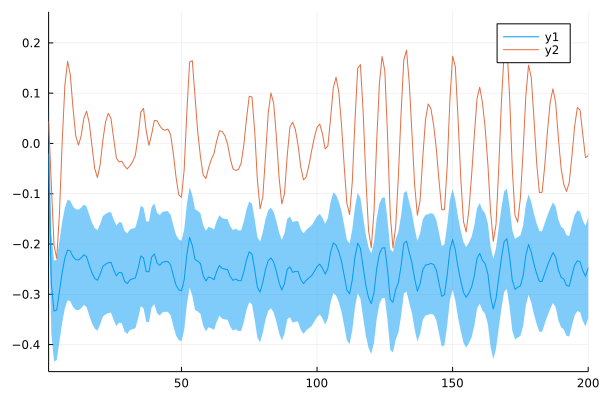

In [413]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 200))

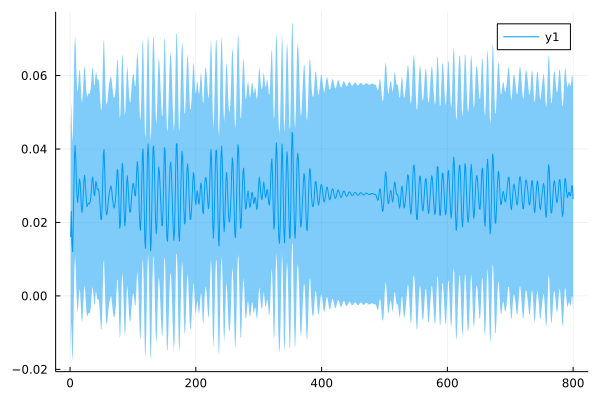

In [414]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))
# plot!(h_gen, xlims=(mfrom, mto))

In [415]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=1);
    
    return fe_[end]
end;

In [493]:
using Optim
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.380783e+04     4.071293e+04
 * time: 0.00011801719665527344
     1     1.242869e+04     1.825188e+03
 * time: 54.415261030197144
     2     1.197243e+04     1.464649e+03
 * time: 145.57130599021912
     3     1.185449e+04     7.694742e+02
 * time: 241.9910590648651
     4     1.148170e+04     1.056030e+03
 * time: 328.45409512519836
     5     1.114301e+04     1.704668e+03
 * time: 382.2607009410858
     6     1.085274e+04     5.505583e+02
 * time: 426.7679350376129
     7     1.065790e+04     7.933746e+02
 * time: 479.3974049091339
     8     1.053567e+04     4.265622e+03
 * time: 510.73848700523376
     9     1.026860e+04     1.259888e+03
 * time: 545.1723709106445
    10     1.019507e+04     1.090380e+03
 * time: 588.873006105423
    11     1.013134e+04     8.273617e+02
 * time: 640.0153450965881
    12     1.012750e+04     5.750912e+02
 * time: 701.054869890213
    13     1.004595e+04     7.131070e+02
 * time: 747.3891129493713


LoadError: InterruptException:

In [494]:
model_params

53-element Vector{Float64}:
   -0.3179695928057278
    0.9776221095017685
   -1.302121139959913
   -0.22534055313176568
    2.2260446301077863
    0.9394246742858201
    1.1017041528684897
    0.7890058448820707
   -0.11671547310971386
    2.643745143350261
    0.9916863399279355
   -2.722437547850197
    0.02618265942906552
    ⋮
   -0.14097933066681662
    0.056465626521546956
   -1.3598184537391496
   -0.4756875171164519
    0.011870407420280213
    0.12450042382811725
   -0.06649373252096849
   -0.011004215429814973
    0.009149482121688793
   -0.029811746891356267
 1000.0
    1.0

In [418]:
inf_params = Optim.minimizer(res)
# inf_params = model_params

53-element Vector{Float64}:
   0.9276411307530243
   1.314785151595159
  -1.639842843657338
  -0.6380131004976052
   2.280910995816567
   0.16376003973849187
   1.1215700667121602
  -0.3195945158868948
   2.54145145985664
   0.6856916276397188
   0.703123433237936
  -3.0710928881697446
   0.39077659242722634
   ⋮
   0.2733498725321668
  -1.6262202098824863
  -1.0924827955223586
  -2.5634162614926974
 -31.46386086605831
 -33.877184885505514
   8.677448357182078
  17.24243095850337
  20.77112878418369
 -42.192416785295386
 999.9793440487783
   6.779124111343387

In [419]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


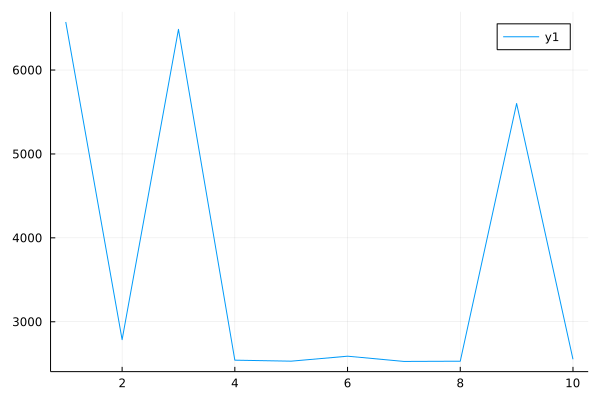

In [420]:
plot(fe_)

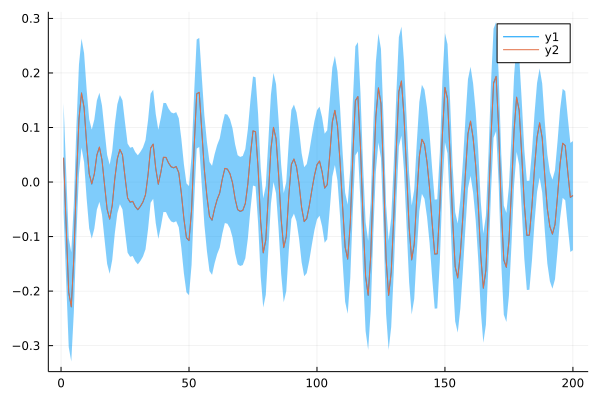

In [421]:
from, to = 1, 200
plot(mean.(y_out_[from:to]), ribbon=sqrt.(cov.(y_out_[from:to])))
plot!(Y_train[from:to])

In [422]:
mean.(h_)

800-element Vector{Vector{Float64}}:
 [-0.023163956585610216, -0.06265095969814387, 0.06892204073391507]
 [-0.01435937694283178, 0.11571705239795864, 1.3709901353778529]
 [-0.01627259074141336, -0.014367346427216633, 0.11721132274519701]
 [-0.026238656068574635, -0.016291994458854143, -0.014436127687061722]
 [-0.027695676317861618, -0.02623806689462645, -0.016290162337734365]
 [-0.030087993127170386, -0.0276958614109204, -0.02623810285818742]
 [-0.02461845520788613, -0.03008692454560415, -0.027695707288444994]
 [-0.025525785082740893, -0.02461734391373532, -0.030086929935521846]
 [-0.03599294948780001, -0.02552396649378425, -0.024616995702661817]
 [-0.053587645382757634, -0.03599402691095785, -0.025524170655685144]
 [-0.05928870351287271, -0.05360905343976651, -0.03599345174429582]
 [-0.05615400614818672, -0.05930431801560786, -0.053603656622287964]
 [-0.04892894487804385, -0.05616010779593359, -0.05929745648894447]
 ⋮
 [-0.03832749039340736, -0.03341295960098613, -0.03215262322854877]

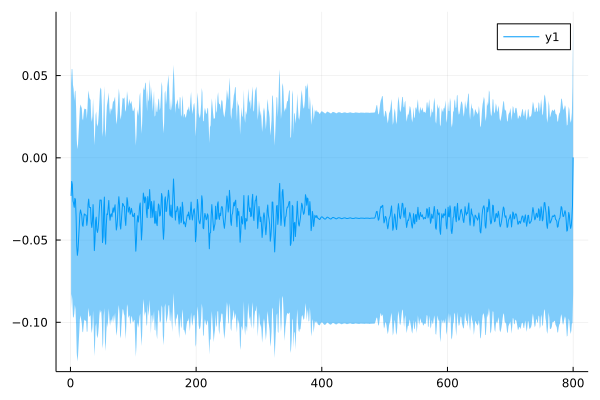

In [423]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [424]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [0.004689779716885149 6.975120492191095e-5 -1.7790300763865816e-7; 6.975120492191095e-5 0.010792511575036695 -2.752669679790612e-5; -1.7790300763865816e-7 -2.752669679790612e-5 0.023532006178891708]
 [0.004680310028525793 -0.00010454162763423828 1.1535757535595542e-5; -0.00010454162763423828 0.004979047212141023 -0.0005494182814763316; 1.1535757535595542e-5 -0.0005494182814763316 0.018122973402015054]
 [0.004923353702935797 -0.00019531674171735443 4.99092322544332e-6; -0.00019531674171735443 0.004686521261061067 -0.00011975454639834041; 4.99092322544332e-6 -0.00011975454639834041 0.004937096629769144]
 [0.004981260829100184 -0.00017101995179748253 6.779643361184175e-6; -0.00017101995179748253 0.004923370106042983 -0.00019517426536064716; 6.779643361184175e-6 -0.00019517426536064716 0.004687250977489825]
 [0.004818804872913817 -0.00013134799905293738 4.5096570333623265e-6; -0.00013134799905293738 0.004981259307876711 -0.00017102484419053964; 4.50965

## KF-like prediction

In [425]:
function transition(γ, order)
    V = zeros(order, order)
#     V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [486]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    prec = 1e2
    h_order = length(h_prior[1])
#     b = zeros(full_order); b[1] = 1.0;
    
    params_flow = params[1:end-full_order-2]
    params_dot  = params[end-full_order-1:end-2]
    params_w    = params[end-1:end]

    b = params_dot;
    
    A = shift(h_order) # transition matrix
    V = transition(params_w[1]/params_w[2], h_order)
    c = zeros(h_order); c[1] = 1.0

    # initialize variables
    y_pred   = datavar(Float64)
    
#     Ys = Y*y_prev
#     Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(full_order)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    Ys ~ MvNormalMeanPrecision(Y*y_prev, prec*diageye(full_order))
    Us ~ MvNormalMeanPrecision(U*u, prec*diageye(full_order))

    hy ~ H*h + Ys
    hyu ~ hy + Us
    
#     y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation(), pipeline = RequireInbound(in )}
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation()}
    
    y_lat_2 ~ dot(y_lat_1, b)

    y_node, y ~ NormalMeanVariance(y_lat_2 + dot(h, c), inv(prec)) where {q = FullFactorisation()}
#     y_node, y ~ NormalMeanVariance(y_lat_2 + dot(h, c), inv(prec))
    
    y_pred ~ NormalMeanVariance(y, 1e12)
#     y ~ Uninformative()
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [487]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(messageout(ReactiveMP.getinterface(y_node, :out)), 
                            (x) -> y_pred_buffer = ReactiveMP.as_message(x))
    

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
#     setmarginal!(y, NormalMeanPrecision(0.0, 0.01))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
#     setmarginal!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [488]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
all_h = [h_prev]
ŵ = inf_params[end-1:end][1]/inf_params[end-1:end][2]
for i in 1:length(X_train)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_train[i], U_train[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_train[i]], [X_train[i]], [U_train[i]], model_flow, inf_params, y_order=order_y, h_prior=h_prev, u_order=order_u, h_order=order_h, vmp_its=1);
    h_prev = (mean.(h_inf)[end], precision.(h_inf)[end])
    push!(all_h, h_prev)
    
end

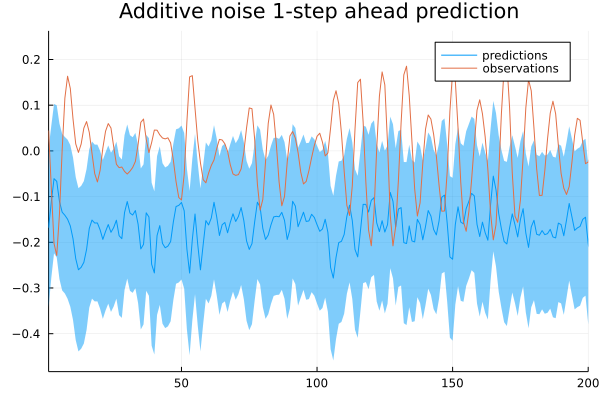

In [492]:
plot(mean.(predictions)/150, ribbon=sqrt.(first.(cov.(predictions)))/150, label="predictions")
plot!(Y_train, xlims=(1, 200), title="Additive noise 1-step ahead prediction", label="observations")

In [485]:
FlowMeta(compile(model_flow, inf_params[1:end-full_order-2]), Linearization())
h = randn(3)
c = zeros(3); c[1] = 1.0;
b = inf_params[end-full_order-1:end-2]
m_in = MvNormalMeanPrecision(Y*X_train[3] + U*U_train[3] + H*h, diageye(full_order))
message_flow = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=Flow_meta)
message_dot_flow = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(randn(6)), m_in2=message_flow, meta=TinyCorrection())
message_h = MvNormalMeanPrecision(h, diageye(3))
message_dot_h = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=message_h, meta=TinyCorrection())
message_sum = @call_rule typeof(+)(:out, Marginalisation) (m_in1=message_dot_flow, m_in2=message_dot_h) 

NormalMeanVariance{Float64}(μ=-6.482093130696579, v=134.56314772253856)